In [1]:
#MODELO DE CLASIFICACIÓN PARA INICIAR EL EJERCICIO DE PRESS MILITAR

#Librerias
from tensorflow.keras.models import Sequential   #Nos ayuda a hacer redes neuronales secuenciales
from tensorflow.keras.layers import Dense, Flatten, Dropout   #Capas
from tensorflow.keras.layers import Convolution2D, MaxPooling2D   #Capas para las convolusiones
from tensorflow.keras.optimizers  import Adam, SGD   #Optimizador para el modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Va a preprocesar las imagenes que le entreguemos, para hacer nuestro dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive  #Conectar con google drive
from sklearn.metrics import classification_report
import cv2
from keras.preprocessing import image

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/drive/MyDrive/Dataset/CORRECTO | wc -l
!ls /content/drive/MyDrive/Dataset/INCORRECTO | wc -l

800
871


In [4]:
rm -rf /content/IMG

In [5]:
#Crear carpetas para hacer el set de datos

!mkdir /content/IMG
!mkdir /content/IMG/DATASET_ENTRENAMIENTO
!mkdir /content/IMG/DATASET_ENTRENAMIENTO/CORRECTO
!mkdir /content/IMG/DATASET_ENTRENAMIENTO/INCORRECTO

!mkdir /content/IMG/DATASET_VALIDACION
!mkdir /content/IMG/DATASET_VALIDACION/CORRECTO
!mkdir /content/IMG/DATASET_VALIDACION/INCORRECTO

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

folders = {
    'CORRECTO': '/content/drive/MyDrive/Dataset/CORRECTO',
    'INCORRECTO': '/content/drive/MyDrive/Dataset/INCORRECTO'
}

image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

def is_image(filename):
    return any(filename.lower().endswith(ext) for ext in image_extensions)

for category, path in folders.items():
    all_images = [os.path.join(path, f) for f in os.listdir(path) if is_image(f)]
    # Limitar la lista de imágenes a un máximo de 800 archivos
    images = all_images[:800]  # Selecciona los primeros 800 archivos

    # Divide los datos en entrenamiento y validación
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    def copy_images(image_list, destination, category):
        cat_dest_path = os.path.join(destination, category)
        if not os.path.exists(cat_dest_path):
            os.makedirs(cat_dest_path)

        for image_path in image_list:
            dest_path = os.path.join(cat_dest_path, os.path.basename(image_path))
            shutil.copy(image_path, dest_path)

    copy_images(train_imgs, '/content/IMG/DATASET_ENTRENAMIENTO', category)
    copy_images(val_imgs, '/content/IMG/DATASET_VALIDACION', category)


In [7]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/IMG/DATASET_ENTRENAMIENTO/CORRECTO | wc -l
!ls /content/IMG/DATASET_ENTRENAMIENTO/INCORRECTO | wc -l

!ls /content/IMG/DATASET_VALIDACION/CORRECTO | wc -l
!ls /content/IMG/DATASET_VALIDACION/INCORRECTO | wc -l

640
640
160
160


In [8]:
#Direccion de nuestro datos
entrenamiento_datos = "/content/IMG/DATASET_ENTRENAMIENTO"
validacion_datos = "/content/IMG/DATASET_VALIDACION"

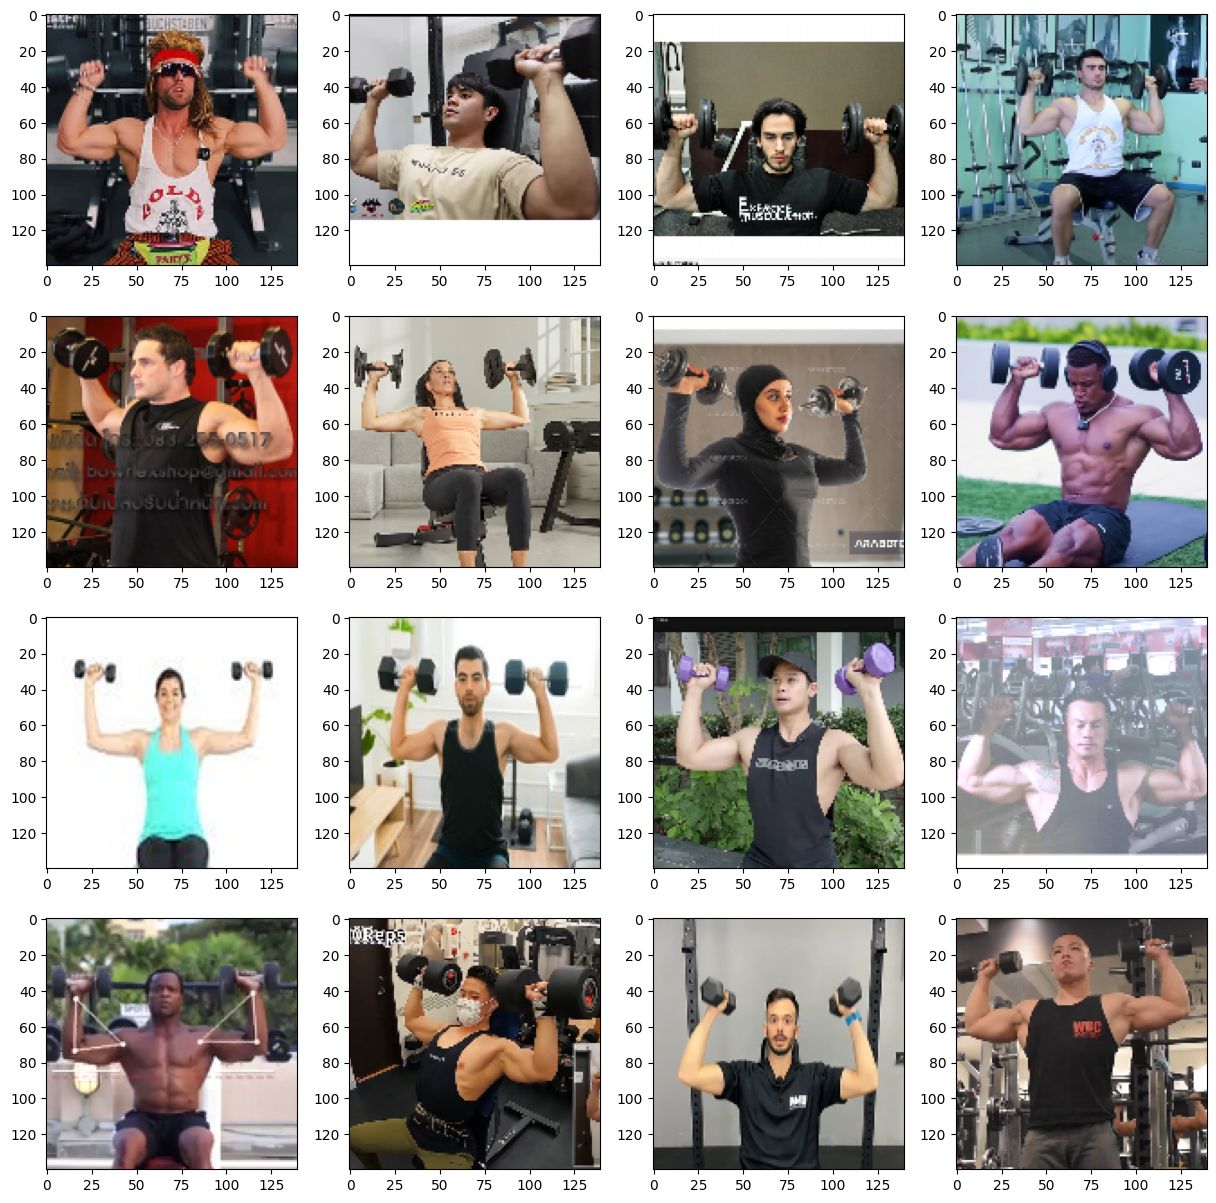

In [9]:
#mostrar imagenes dentro de carpeta correcto

plt.figure(figsize=(15,15))

carpeta='/content/IMG/DATASET_VALIDACION/CORRECTO'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:16]):
    plt.subplot(4, 4, i+1)
    imagen = mpimg.imread(carpeta + '/' + nombreimg) #/content/DATASET/CORRECTO/nombreimg
    imagen = cv2.resize(imagen, (140,140), interpolation = cv2.INTER_CUBIC)
    plt.imshow(imagen)

In [10]:
#Parametros

#Para ajustar las imagenes
alto, ancho = 128, 128  #Tamaño de las imagenes
batch_size = 1  #Cantidad de imagenes a enviar

#Para entrenar el modelo
iteraciones = 15  #Cantidad de iteraciones para entrenar el modelo
pasos = 1280/batch_size  #Número de veces que se procesa la información de entrenamiento por iteración
pasos_validacion = 320/batch_size #Al momento de entrenar se va a validar
numero_clases = 2   #El número de neuronas en la capa de salida (CORRECTO,INCORRECTO)
tasa_aprendizaje = 0.0002   #Ajuste para que el modelo sea mas confiable

#Para las capas de convolución
#Filtros para cada capa de convolución
convolucion_filtro1 = 32
convolucion_filtro2 = 64
convolucion_filtro3 = 128
convolucion_filtro4 = 256

#Tamaños de los filtros
tamanio_filtro1 = (3,3)
tamanio_filtro2 = (3,3)
tamanio_filtro3 = (2,2)
tamanio_filtro4 = (2,2)
#Tamaño del filtro del maxPooling
tamanio_pool = (2,2)


In [11]:
# Configuracion para pre-procesar las imagenes de entrenamiento
entrenamiento_preprocesamiento = ImageDataGenerator(
    rescale = 1./255,         #Los pixeles ahora tomaran valores 0 | 1.
    zoom_range=[0.97,1.02],  # Generar imágenes con zoom
    width_shift_range=[0.02,0.04],# Mover imagen en eje x
    height_shift_range=[0.02,0.06],# Mover imagen en eje y
    horizontal_flip=True,  # Invierte las imágenes (aplica modo espejo)
    fill_mode="nearest"    # Rellenar el espacio generado al mover la imagen
)

In [12]:
# Configuracion para pre-procesar las imagenes de validacion
validacion_preprocesamiento = ImageDataGenerator(
    rescale = 1./255         #Los pixeles ahora tomaran valores 0 | 1.
)

In [13]:

#Armar el dataset de imagenes de entrenamiento
imagenes_entrenamiento = entrenamiento_preprocesamiento.flow_from_directory(
    entrenamiento_datos,         #Direccion de los datos de entrenamiento
    target_size = (alto,ancho),
    batch_size = batch_size,
    class_mode = 'categorical'  #se clasifica por clases (correcto-incorrecto)
)



Found 1280 images belonging to 2 classes.


In [14]:
imagenes_validacion = validacion_preprocesamiento.flow_from_directory(
    validacion_datos,         #Direccion de los datos de validacion
    target_size = (alto,ancho),
    batch_size = batch_size,
    class_mode = 'categorical'  #se clasifica por clases (correcto-incorrecto)
)

Found 320 images belonging to 2 classes.


In [15]:
imagenes_entrenamiento.class_indices

{'CORRECTO': 0, 'INCORRECTO': 1}

In [16]:
imagenes_validacion.class_indices

{'CORRECTO': 0, 'INCORRECTO': 1}

In [17]:
#Creamos la red neuronal
cnn = Sequential()
#Agregamos las capas convolusionales y de max pooling
cnn.add(Convolution2D(convolucion_filtro1, tamanio_filtro1, input_shape = (alto,ancho,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = tamanio_pool))

cnn.add(Convolution2D(convolucion_filtro2, tamanio_filtro2, activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = tamanio_pool))


cnn.add(Convolution2D(convolucion_filtro3, tamanio_filtro3, activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = tamanio_pool))

cnn.add(Convolution2D(convolucion_filtro4, tamanio_filtro4, activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = tamanio_pool))

#cnn.add(Dropout(0.5))
#Vamos a convertir la imagen profunda en informacion que pueda ser leiada por las capas dense
cnn.add(Flatten())  #Aplanar
#cnn.add(Dropout(0.5))

#Primera capa Dense
cnn.add(Dense(100, activation = 'relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(50, activation = 'relu'))
cnn.add(Dropout(0.5))
#cnn.add(Dropout(0.5))

#Capa de salida
cnn.add(Dense(numero_clases, activation = 'softmax'))

In [18]:
#Compilar y optimizar el modelo
optimizar = Adam(learning_rate = tasa_aprendizaje)
#optimizar = SGD(learning_rate=0.0002)
cnn.compile(loss = 'categorical_crossentropy', optimizer = optimizar, metrics = ['accuracy'])

In [19]:
#Entrenamiento del modelo
cnn.fit(imagenes_entrenamiento,
        steps_per_epoch = pasos, epochs = iteraciones,
        validation_data = imagenes_validacion, validation_steps = pasos_validacion)

Epoch 1/15
1280/1280 [==============================] - 79s 60ms/step - loss: 0.6958 - accuracy: 0.5086 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/15
1280/1280 [==============================] - 80s 63ms/step - loss: 0.6940 - accuracy: 0.5297 - val_loss: 0.6907 - val_accuracy: 0.5406
Epoch 3/15
1280/1280 [==============================] - 73s 57ms/step - loss: 0.6821 - accuracy: 0.5680 - val_loss: 0.6199 - val_accuracy: 0.7000
Epoch 4/15
1280/1280 [==============================] - 74s 58ms/step - loss: 0.6170 - accuracy: 0.6609 - val_loss: 0.6116 - val_accuracy: 0.6844
Epoch 5/15
1280/1280 [==============================] - 71s 56ms/step - loss: 0.5793 - accuracy: 0.6961 - val_loss: 0.5247 - val_accuracy: 0.7437
Epoch 6/15
1280/1280 [==============================] - 75s 59ms/step - loss: 0.5323 - accuracy: 0.7594 - val_loss: 0.5034 - val_accuracy: 0.7844
Epoch 7/15
1280/1280 [==============================] - 76s 59ms/step - loss: 0.5022 - accuracy: 0.7727 - val_loss: 0.4336 -

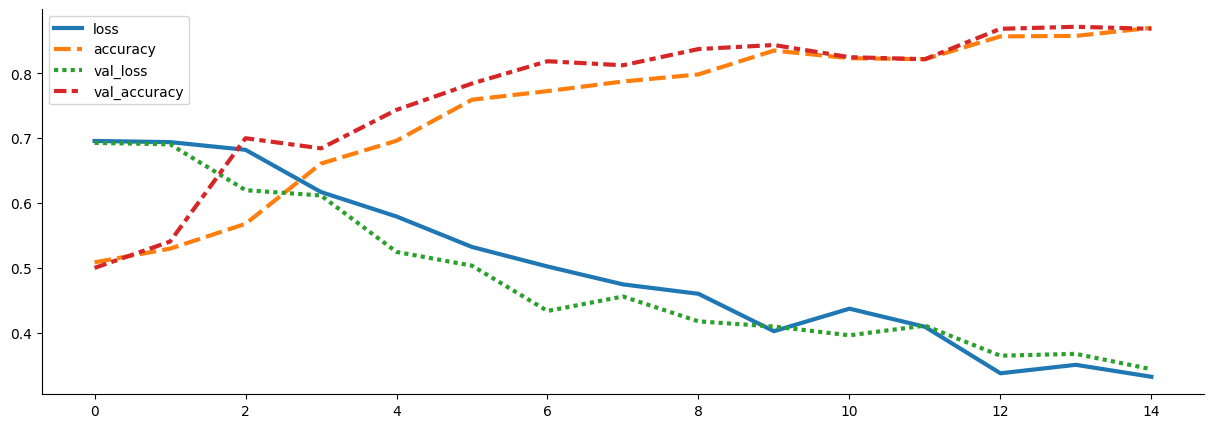

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Vamos a verificar los daros de perdida con la media cuadratica
loss = pd.DataFrame(cnn.history.history)
plt.figure(figsize=(15,5))
sns.lineplot(data = loss, lw = 3)
sns.despine()

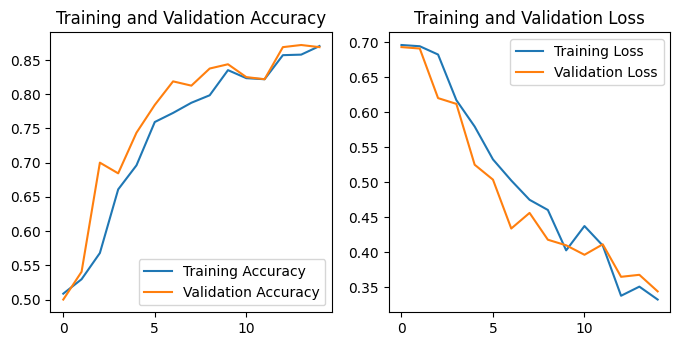

In [21]:
acc = cnn.history.history['accuracy']
val_acc = cnn.history.history['val_accuracy']

loss = cnn.history.history['loss']
val_loss = cnn.history.history['val_loss']
epochs_range = range(iteraciones)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **VERIFICAR IMÁGENES Y ETIQUETAS**

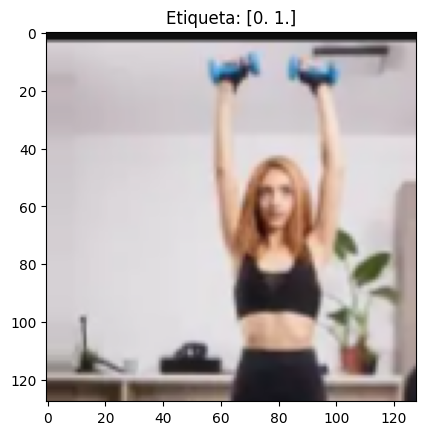

In [22]:
#DATOS DE ENTRENAMIENTO
# Acceder al algún batch
imagenes, etiquetas = imagenes_entrenamiento[0]

# Seleccionar la primera imagen y su etiqueta
im = imagenes[0]
etiqueta = etiquetas[0]

# Visualizar la imagen
plt.imshow(im)
plt.title(f'Etiqueta: {etiqueta}')
plt.show()

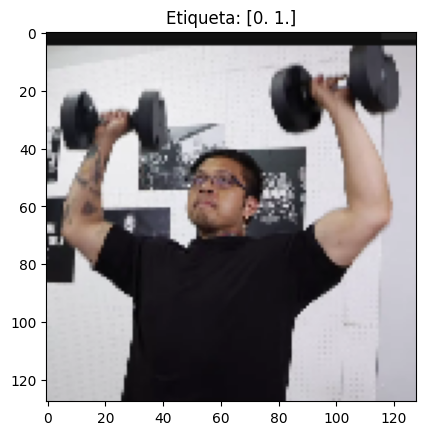

In [23]:
#DATOS DE VALIDACIÓN
# Acceder al algún batch
imagenes, etiquetas = imagenes_validacion[0]

# Seleccionar la primera imagen y su etiqueta
im = imagenes[0]
etiqueta = etiquetas[0]

# Visualizar la imagen
plt.imshow(im)
plt.title(f'Etiqueta: {etiqueta}')
plt.show()


# **CLASIFICATION REPORT Y MATRIZ DE CONFUSIÓN**

In [24]:
def indices_de_maximos_np(arrays):
    # np.argmax devuelve los índices de los máximos a lo largo del eje especificado, que es 1 en este caso para iterar sobre cada sub-array.
    return np.array(np.argmax(arrays, axis=1))

In [25]:
#OBTENER LAS ETIQUETAS DE LAS IMÁGENES DE ENTRENAMIENTO
# Lista para almacenar las etiquetas
indices_imagenes_entrenamiento = []

# Iterar sobre el generador
for i in range(len(imagenes_entrenamiento)):
    _, etiquetas = imagenes_entrenamiento[i]
    indices_imagenes_entrenamiento.extend(etiquetas)

#Obtener la clase a la que pertenece la imagen
indices_imagenes_entrenamiento = indices_de_maximos_np(indices_imagenes_entrenamiento)

In [26]:
#OBTENER LAS ETIQUETAS DE LAS IMÁGENES DE VALIDACIÓN
# Lista para almacenar las etiquetas
indices_imagenes_validacion = []

# Iterar sobre el generador
for i in range(len(imagenes_validacion)):
    _, etiquetas = imagenes_validacion[i]
    indices_imagenes_validacion.extend(etiquetas)

#Obtener la clase
indices_imagenes_validacion = indices_de_maximos_np(indices_imagenes_validacion)

In [27]:
#Realizamos la predicción
imagenes_pred_entre = cnn.predict(imagenes_entrenamiento)
imagenes_pred_valid = cnn.predict(imagenes_validacion)

320/320 [==============================] - 7s 21ms/step


In [28]:
#Obtenemos el resultado de las predicciones
prediccion_entrenamiento = indices_de_maximos_np(imagenes_pred_entre)
prediccion_validacion = indices_de_maximos_np(imagenes_pred_valid)

In [29]:
#CLASIFICATION REPORT ENTRENAMIENTO
print(classification_report(indices_imagenes_entrenamiento, prediccion_entrenamiento))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       640
           1       0.93      0.88      0.91       640

    accuracy                           0.91      1280
   macro avg       0.91      0.91      0.91      1280
weighted avg       0.91      0.91      0.91      1280



In [30]:
from sklearn.metrics import confusion_matrix
#Matriz de confusion es solo para clasificacion, no para regresion
confusion_matrix(indices_imagenes_entrenamiento, prediccion_entrenamiento)

array([[599,  41],
       [ 75, 565]])

In [31]:
#CLASIFICATION REPORT VALIDACION
print(classification_report(indices_imagenes_validacion, prediccion_validacion))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       160
           1       0.92      0.81      0.86       160

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



In [32]:
confusion_matrix(indices_imagenes_validacion, prediccion_validacion)

array([[149,  11],
       [ 31, 129]])

# **GUARDAR MODELO**

In [33]:
#Guardamos el modelo y los pesos
#cnn.save("Modelo_softmax.h5")
#cnn.save_weights("Pesos_softmax.h5")

# **REALIZAR PREDICCIONES**

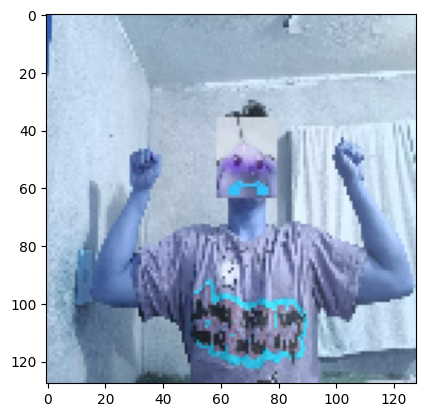

In [36]:
import cv2
imagen = cv2.imread('/content/correcto.jpeg')
imagen = cv2.resize(imagen, (alto,ancho), interpolation = cv2.INTER_CUBIC)
plt.imshow(imagen)

In [37]:
x = image.img_to_array(imagen)
x = np.expand_dims(x,axis = 0)

In [38]:
vector = cnn.predict(x)
resultado = vector[0]
print(vector)
resultado = np.argmax(resultado)
resultado

1/1 [==============================] - 0s 114ms/step
[[3.4429775e-07 9.9999964e-01]]


1

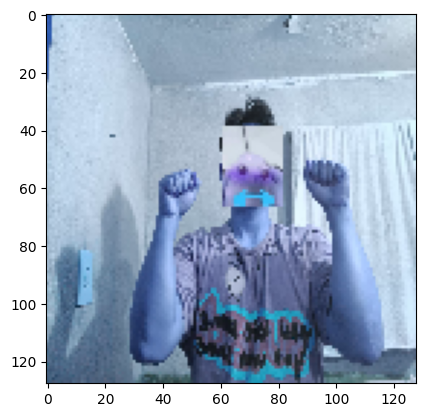

In [39]:
imagen2 = cv2.imread('/content/incorrecto.jpeg')
imagen2 = cv2.resize(imagen2, (alto,ancho), interpolation = cv2.INTER_CUBIC)
plt.imshow(imagen2)

In [40]:
x2 = image.img_to_array(imagen2)
x2 = np.expand_dims(x2,axis = 0)

In [41]:
vector2 = cnn.predict(x2)
print(vector2)
resultado2 = vector2[0]
resultado2 = np.argmax(resultado2)
resultado2

1/1 [==============================] - 0s 30ms/step
[[0. 1.]]


1

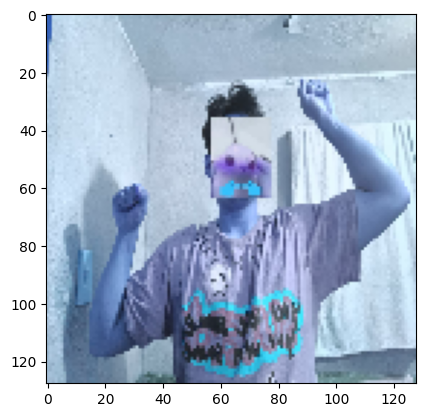

In [50]:
imagen3 = cv2.imread('/content/incorrecto2.jpeg')
imagen3 = cv2.resize(imagen3, (alto,ancho), interpolation = cv2.INTER_CUBIC)
plt.imshow(imagen3)

In [51]:
x3 = image.img_to_array(imagen3)
x3 = np.expand_dims(x3,axis = 0)

In [52]:
vector3 = cnn.predict(x3)
vector3

1/1 [==============================] - 0s 28ms/step


array([[1., 0.]], dtype=float32)

In [53]:
resultado3 = vector3[0]
print(vector3)
resultado3 = np.argmax(resultado3)
resultado3

[[1. 0.]]


0

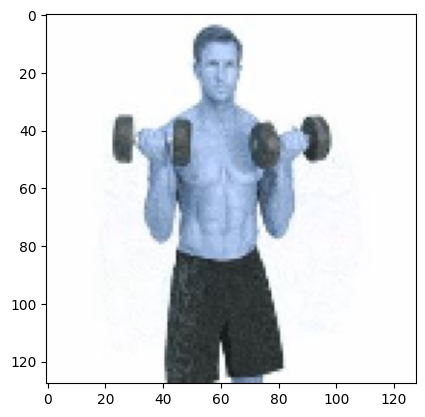

In [54]:
imagen4 = cv2.imread('/content/incorrecto4.JPG')
imagen4 = cv2.resize(imagen4, (alto,ancho), interpolation = cv2.INTER_CUBIC)
plt.imshow(imagen4)

In [55]:
x4 = image.img_to_array(imagen4)
x4 = np.expand_dims(x4,axis = 0)
vector4 = cnn.predict(x4)
print(vector4)
resultado4 = vector4[0]
resultado4 = np.argmax(resultado4)
resultado4

1/1 [==============================] - 0s 30ms/step
[[1. 0.]]


0

In [163]:
pat='/content/incorrecto_4.jpeg'

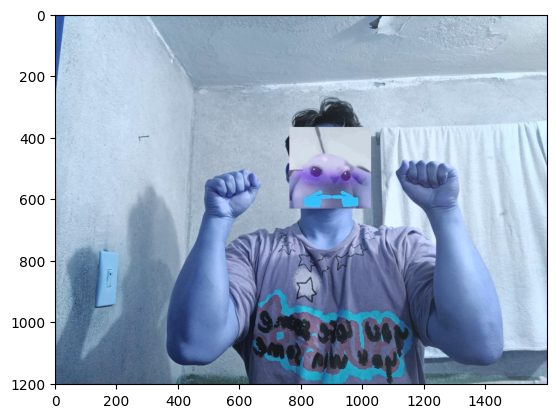

In [164]:
imag = cv2.imread(pat)
plt.imshow(imag)

In [165]:
xa = image.img_to_array(image.load_img(pat, target_size=(alto, ancho)))
xa = np.expand_dims(xa,axis = 0)

In [166]:
vecto = cnn.predict(xa)
print(vecto)
resulta = vecto[0]
resulta = np.argmax(resulta)
resulta

1/1 [==============================] - 0s 47ms/step
[[0. 1.]]


1